# First pass, OPTION A

This is the first pass of my TFG, the idea of processing the image and being able to detect features and such


### Loading Libraries

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

ModuleNotFoundError: No module named 'torchvision'

### Loading data

It is necessary that, before starting the detection of objects we prosses the images so that they are selected and well suited for analizis. That's why we need to separate the cloth from the background. An option might be the use of a machine learning algorithm to detect the cloth from a picture

In [2]:
pant_img_original = cv2.imread(r'GoodUp.jpg')

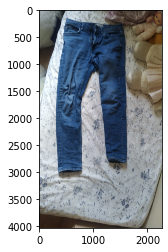

In [3]:
pant_img_original = cv2.imread(r'GoodUp.jpg')
pant_img = pant_img_original[:,:,::-1]
plt.imshow(pant_img)

In [4]:
pant_img_gray = cv2.cvtColor(pant_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(pant_img_gray, (7, 7), 0)
(thresh, blackAndWhiteImage) = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


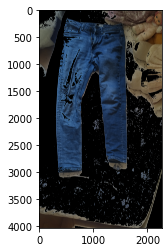

In [5]:
invertedMask = cv2.bitwise_not(blackAndWhiteImage)
newImage = cv2.bitwise_or(pant_img, pant_img, mask = invertedMask)
plt.imshow(newImage)

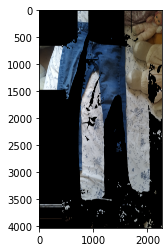

In [6]:
kernelClose = np.ones((10,10),np.uint8)
redoneInverted = invertedMask
for x in range(15):
    redoneInverted = cv2.morphologyEx(redoneInverted, cv2.MORPH_CLOSE, kernelClose)
for x in range(400):
    redoneInverted = cv2.morphologyEx(redoneInverted, cv2.MORPH_OPEN, kernelClose)
newImage = cv2.bitwise_or(pant_img, pant_img, mask = redoneInverted)
plt.imshow(newImage)

# Machine Learning to detect pants

## Load data

In [80]:
dataCSV = pd.read_csv('Data/images.csv')
dataCSV.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [86]:
typeOfData = dataCSV["label"].value_counts()
typeOfData

Top             1432
Longsleeve       699
Bottom_Long      692
Shoes            431
Dress            357
Outwear          312
Bottom_Short     308
Not sure         228
Hat              171
Skirt            155
Polo             120
Undershirt       118
Blazer           109
Hoodie           100
Body              69
Other             67
Blouse            23
Skip              12
Name: label, dtype: int64

## Data cleaning

Since most of the data has been categorized, and we are mostly interested on some of the labels, and not all, to simplify and improve the training process, we are going to remove some of the categories. And transform them into a single type. We will transform those labels into, Top, Shorts, Pants, and remove some

The label Top will contain:
T-Shirt
LongSleeve
Shirt

The label Bottom will contain:
Pants

The other Shorts will contain:
Shorts

The removed ones will be:
Skirt
Dress
OutWear
Hat
Blazer
Hoodie
Skip
Blouse
Top
Polo
Undershirt.

Also, all data regarding kids will be removed too

In [82]:
dataCSV['image'] = dataCSV['image'] +'.jpg' #We adjust the data so that it is well defined
dataCSV.dropna()

dataCSV.loc[dataCSV['label'] == 'T-Shirt','label'] = 'Top'
dataCSV.loc[dataCSV['label'] == 'LongSleeve','label'] = 'Top'
dataCSV.loc[dataCSV['label'] == 'Shirt','label'] = 'Top'

dataCSV.loc[dataCSV['label'] == 'Pants','label'] = 'Bottom_Long'

dataCSV.loc[dataCSV['label'] == 'Shorts','label'] = 'Bottom_Short'
kidsRemoved = dataCSV.loc[dataCSV["kids"] == "False"]

newColumns = ['Top','Bottom_Long', 'Bottom_Short']
finalData = dataCSV.loc[dataCSV["label"].str.contains("Top|Bottom_Long|Bottom_Short")]
data_df = finalData[['image', 'label']]

Now we can check our new data

In [88]:
typeOfData = data_df["label"].value_counts()
data_df.head()
typeOfData

Top             1432
Bottom_Long      692
Bottom_Short     308
Name: label, dtype: int64

## Linking images

In [98]:
imagesPath = 'Data/clothing-dataset-full/images_original'
def getImage(route): return path+route['image']
def getLabel(route): return route['label']

It would be interesting to use a pretrained model so that the training process is slowed down, and potentially, we will get better results. To avoid retraining it, we can use a common model like resNet. Therefore we can make use of pythorch pretrained models.

In [110]:
resnet18 = models.resnet18(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Switching to GPU if available

### Prepare data to train the model downloaded

Extracted from https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18/notebook

https://www.kaggle.com/marissafernandes/clothes-image-classifier/notebook

In [114]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ClothDataSet(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
#        if self.mode == 'train':
#            if 'dog' in self.file_list[0]:
#                self.label = 1
#            else:
#                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = ClothDataSet(cat_files, train_dir, transform = data_transform)
dogs = ClothDataSet(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])